# Data

In [18]:
import pandas as pd
import numpy as np

df = pd.DataFrame( columns = ['cat_1', 'cat_2'] )

n = 4
m = 5

sample_size = 100

df['cat_1'] = np.random.randint(1, n, sample_size)
df['cat_2'] = np.random.randint(1, m, sample_size)
df['random_x'] = np.random.random(sample_size)

beta = 2.0*np.random.rand()

shift_cat1 = np.random.rand(df['cat_1'].nunique())
shift_cat2 = np.random.rand(df['cat_2'].nunique())

df['random_y'] = beta* df['random_x'] + 0.1*np.random.rand(sample_size)
df['random_y'] = df['random_y'] + shift_cat1[df['cat_1'].values - 1] + shift_cat2[df['cat_2'].values - 1]

# Data Visualization

In the presence of noise, lets visualization the data.

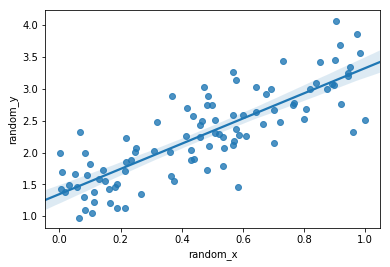

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.regplot( x = df['random_x'], y = df['random_y'])
plt.show()

This data is very noisy.  We may not get good results at all due to the noise.  Lets see how the Bayesian model handles the noise.

# Modelling

Fitting our model to the data will take a while, please be patient.

In [20]:
from bayes_linear import BGLRegressor

model = BGLRegressor(numeric_cols = ['random_x'], target_col = 'random_y', cat_cols = ['cat_1', 'cat_2'])

In [21]:
model.fit(df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7cd9ddc432e549b0793f0fc7c6e70a35 NOW.
/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [22]:
print(model.model)

Inference for Stan model: anon_model_7cd9ddc432e549b0793f0fc7c6e70a35.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_cat_1         1.98  8.3e-3   0.39   1.18   1.72   1.99   2.23   2.73   2202    1.0
mu_cat_2         2.11    0.02   0.34   1.48   1.86   2.11   2.35   2.79    499   1.01
mu_b             0.87    0.51  19.47 -44.13  -5.85   1.89   8.31   42.3   1439    1.0
sigma_cat_1      2.33    0.07   1.09   0.27   1.68   2.27    3.0   4.66    254   1.02
sigma_cat_2      0.75    0.08   0.88   0.13   0.24   0.38    0.8   3.42    133   1.03
sigma_b          15.8    0.55  12.15   0.39   6.04  13.51  22.75  45.06    485   1.01
sigma            0.29  5.4e-4   0.02   0.25   0.27   0.29    0.3   0.34   1643   1.01
beta[0]          2.01  2.0e-3    0.1   1.81   1.94    2.0   2.07    2.2   2540    1.0
shift_cat_1[0]  -0.07    0.09   0.97 

# Validation Performance

In [23]:
df_val = pd.DataFrame( columns = ['random_x'])

df_val['random_x'] = np.random.rand(100)

df_val['cat_1'] = np.random.randint(1, n, 100)
df_val['cat_2'] = np.random.randint(1, m, 100)

y_val = beta*df_val['random_x'].values + shift_cat1[df_val['cat_1'].values - 1] + shift_cat2[df_val['cat_2'].values - 1]

Lets visualization the data before we test our metrics

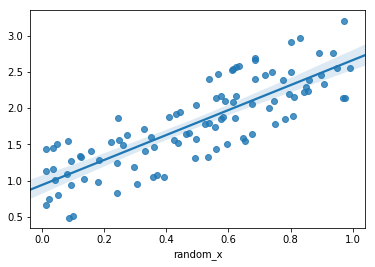

In [24]:
sns.regplot( x = df_val['random_x'], y = y_val )
plt.show()

In [25]:
r2_score_train = model.score(df, df['random_y'])
r2_score_val = model.score(df_val, y_val)

print('The train R^2 score is: ' + str( round(r2_score_train, 4)))
print('The validation R^2 score is: ' + str( round(r2_score_val, 4)))

The train R^2 score is: 0.8471
The validation R^2 score is: 0.2742


Now lets compare to Linear Regression and Ridge Regression

# Prediction Visualization

In [26]:
y_val_pred = model.predict(df_val)

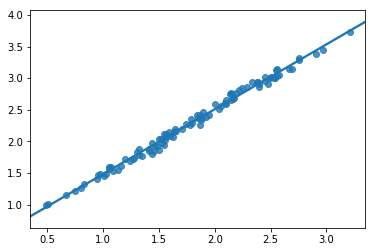

In [27]:
sns.regplot( x = y_val, y = y_val_pred )

plt.show()

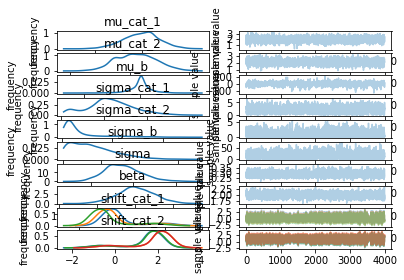

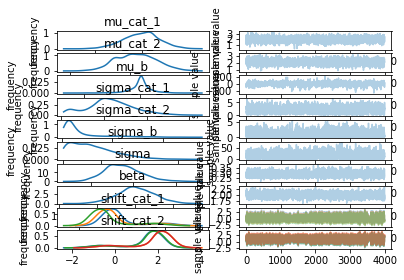

In [28]:
model.model.plot()

# Non-Bayesian Performance

## Label Encoded Data

### Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit( df[['random_x', 'cat_1', 'cat_2']], df['random_y'] )

r2_score_train = lin_reg.score( df[['random_x', 'cat_1', 'cat_2']], df['random_y'] )
r2_score_val = lin_reg.score( df_val[['random_x', 'cat_1', 'cat_2']], y_val )

print('The train R^2 score is: ' + str( round(r2_score_train, 4)))
print('The validation R^2 score is: ' + str( round(r2_score_val, 4)))

The train R^2 score is: 0.7959
The validation R^2 score is: 0.2755


### Ridge Regression

In [30]:
from sklearn.linear_model import RidgeCV

lin_reg = RidgeCV( cv = 5 )

lin_reg.fit( df[['random_x', 'cat_1', 'cat_2']], df['random_y'] )

r2_score_train = lin_reg.score( df[['random_x', 'cat_1', 'cat_2']], df['random_y'] )
r2_score_val = lin_reg.score( df_val[['random_x', 'cat_1', 'cat_2']], y_val )

print('The train R^2 score is: ' + str( round(r2_score_train, 4)))
print('The validation R^2 score is: ' + str( round(r2_score_val, 4)))

The train R^2 score is: 0.7958
The validation R^2 score is: 0.279


## Ont-Hot Encoded Data

### Feature Engineering

In [31]:
df_val['random_y'] = y_val

df['is_train'] = 1
df_val['is_train'] = 0

merged_df = pd.concat( [df, df_val], axis = 0, ignore_index = True )

def oneHotEncode(dff, cat_cols ):
    
    res = dff.copy()
    
    for cat_col in cat_cols:
        
        cat_dummies = pd.get_dummies( res[cat_col].astype(object) )
        cat_dummies = cat_dummies.rename( columns = {col : cat_col + '_' + str(col) for col in cat_dummies.columns} )
        
        res = pd.concat( [res.drop(cat_col, axis = 1), cat_dummies], axis = 1 )
        
    return res


merged_df_one_hot_encoded = oneHotEncode( merged_df.copy(), ['cat_1', 'cat_2'] )

indices = merged_df_one_hot_encoded['is_train'] == 1

df_one_hot_encoded = merged_df_one_hot_encoded.loc[indices, :].reset_index(drop = True)
df_val_one_hot_encoded = merged_df_one_hot_encoded.loc[~indices, :].reset_index(drop = True)

train_cols = [ col for col in df_one_hot_encoded.columns if not col in ['is_train', 'random_y'] ]

### Linear Regression

In [32]:
lin_reg = LinearRegression()

lin_reg.fit( df_one_hot_encoded[train_cols], df['random_y'] )

r2_score_train = lin_reg.score( df_one_hot_encoded[train_cols], df['random_y'] )
r2_score_val = lin_reg.score( df_val_one_hot_encoded[train_cols], y_val )

print('The train R^2 score is: ' + str( round(r2_score_train, 4)))
print('The validation R^2 score is: ' + str( round(r2_score_val, 4)))

The train R^2 score is: 0.8473
The validation R^2 score is: 0.2774


### Ridge Regression

In [33]:
lin_reg = RidgeCV( cv = 5 )

lin_reg.fit( df_one_hot_encoded[train_cols], df['random_y'] )

r2_score_train = lin_reg.score( df_one_hot_encoded[train_cols], df['random_y'] )
r2_score_val = lin_reg.score( df_val_one_hot_encoded[train_cols], y_val )

print('The train R^2 score is: ' + str( round(r2_score_train, 4)))
print('The validation R^2 score is: ' + str( round(r2_score_val, 4)))

The train R^2 score is: 0.8472
The validation R^2 score is: 0.2805


Now we have arguably better results, but with a price to pay.  We had to engineer new features, and increase our feature space by the sum of the unique values per categorial features we have in our model. Our Bayesian model takes care of that for us, without having to engineer those features.   

# Comments

This shows that, with the presence of white noise, the Bayesian model is more equipped to learn from noisy data and make better predictions, while also taking care of the categorial differences in the data. The Ridge regression, made to control the scale of the weights and prevent overfitting, does a poorer job than the Bayesian model.